# FCT Analysis: CDF Plots

This notebook analyzes Flow Completion Time (FCT) data and plots:
1. CDF of FCT values
2. CDF of FCT/Ideal FCT ratios (slowdown)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [3]:
# Load the FCT data
data_file = "testbed/eval_train/0/ns3/fct_topology_flows.txt"

# Read the data - columns are: flowId, sip, dip, sport, dport, size, start_time, fct, ideal_fct
column_names = ['flow_id', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'size', 'start_time', 'fct', 'ideal_fct']

df = pd.read_csv(data_file, sep=' ', header=None, names=column_names)
print(f"Loaded {len(df)} flows")
print(f"Data shape: {df.shape}")
df.head()


Loaded 3897 flows
Data shape: (3897, 9)


,flow_id,src_ip,dst_ip,src_port,dst_port,size,start_time,fct,ideal_fct
0,0,0b10000000001,0b100000001,10000,100,17,0,2517266500,2013
1,1,0b1000000001,0b100000001,10000,100,17,602523,2515222545,2013
2,2,0b10100000001,0b100000001,10000,100,17,12075472,2711013687,2013
3,3,0b100000001,0b1000000001,10000,100,13,2516672199,14537,2010
4,4,0b1000000001,0b100000001,10000,100,17,2516710051,192642262,2013


In [4]:
# Basic statistics
print("=== FCT Statistics ===")
print(f"FCT (ns) - Min: {df['fct'].min():,}, Max: {df['fct'].max():,}, Mean: {df['fct'].mean():.2f}")
print(f"Ideal FCT (ns) - Min: {df['ideal_fct'].min():,}, Max: {df['ideal_fct'].max():,}, Mean: {df['ideal_fct'].mean():.2f}")

# Calculate slowdown (FCT / Ideal FCT)
df['slowdown'] = df['fct'] / df['ideal_fct']
print(f"\n=== Slowdown Statistics ===")
print(f"Slowdown - Min: {df['slowdown'].min():.3f}, Max: {df['slowdown'].max():.3f}, Mean: {df['slowdown'].mean():.3f}")
print(f"Median slowdown: {df['slowdown'].median():.3f}")
print(f"95th percentile slowdown: {df['slowdown'].quantile(0.95):.3f}")
print(f"99th percentile slowdown: {df['slowdown'].quantile(0.99):.3f}")


=== FCT Statistics ===
FCT (ns) - Min: 3,089, Max: 2,711,013,687, Mean: 2110471.13
Ideal FCT (ns) - Min: 2,000, Max: 2,036, Mean: 2017.14

=== Slowdown Statistics ===
Slowdown - Min: 1.535, Max: 1346752.949, Mean: 1048.417
Median slowdown: 1.891
95th percentile slowdown: 2.214
99th percentile slowdown: 4.682


In [ ]:
def plot_cdf(data, label, ax, color=None, linestyle='-'):
    """Plot CDF of the given data"""
    sorted_data = np.sort(data)
    n = len(sorted_data)
    y = np.arange(1, n + 1) / n
    
    ax.plot(sorted_data, y, label=label, color=color, linestyle=linestyle, linewidth=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('CDF')
    ax.legend()
    
    return ax


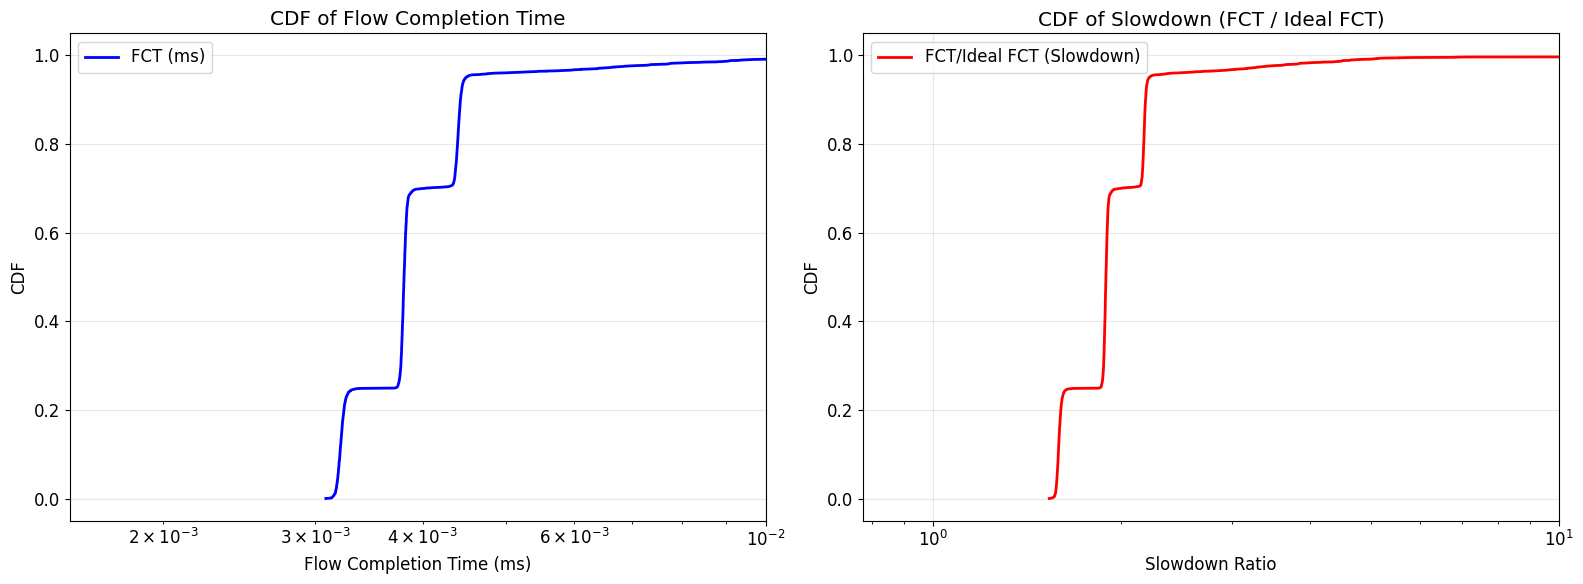

In [17]:
# Create the main CDF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: CDF of FCT values
plot_cdf(df['fct'] / 1e6, 'FCT (ms)', ax1, color='blue')  # Convert ns to ms
ax1.set_xlabel('Flow Completion Time (ms)')
ax1.set_title('CDF of Flow Completion Time')
ax1.set_xscale('log')
ax1.set_xlim(right=0.01)  # Set x-axis limit to 10 ms

# Plot 2: CDF of FCT/Ideal FCT ratio (slowdown)
plot_cdf(df['slowdown'], 'FCT/Ideal FCT (Slowdown)', ax2, color='red')
ax2.set_xlabel('Slowdown Ratio')
ax2.set_title('CDF of Slowdown (FCT / Ideal FCT)')
ax2.set_xscale('log')
ax2.set_xlim(right=10)  # Set x-axis limit to 10 ms

plt.tight_layout()
plt.show()


In [7]:
# Percentile analysis
percentiles = [50, 90, 95, 99, 99.9]

print("=== Percentile Analysis ===")
print("Percentile\tFCT (ms)\tSlowdown")
print("-" * 40)

for p in percentiles:
    fct_p = df['fct'].quantile(p/100) / 1e6  # Convert to ms
    slowdown_p = df['slowdown'].quantile(p/100)
    print(f"{p:>6}th\t{fct_p:>8.3f}\t{slowdown_p:>8.3f}")


=== Percentile Analysis ===
Percentile	FCT (ms)	Slowdown
----------------------------------------
    50th	   0.004	   1.891
    90th	   0.004	   2.188
    95th	   0.004	   2.214
    99th	   0.009	   4.682
  99.9th	 194.012	96379.394


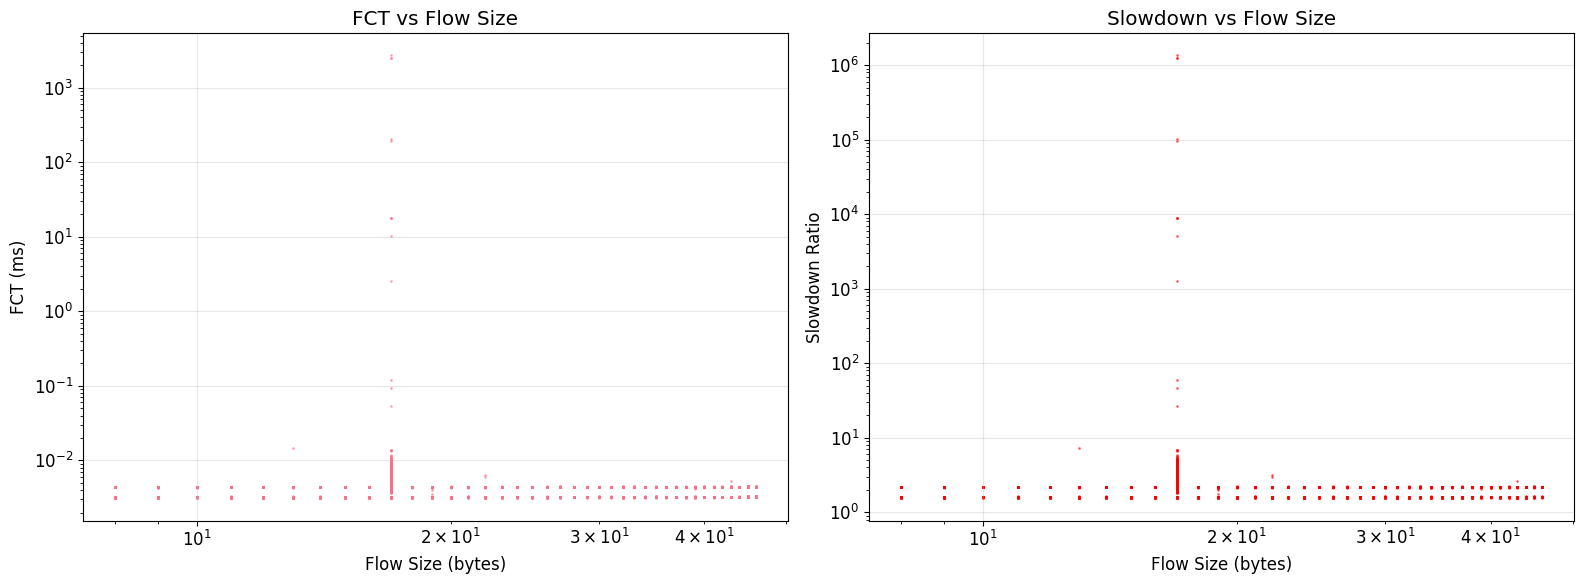

In [8]:
# Additional analysis: FCT vs Flow Size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# FCT vs Size scatter plot
ax1.scatter(df['size'], df['fct'] / 1e6, alpha=0.5, s=1)
ax1.set_xlabel('Flow Size (bytes)')
ax1.set_ylabel('FCT (ms)')
ax1.set_title('FCT vs Flow Size')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Slowdown vs Size scatter plot
ax2.scatter(df['size'], df['slowdown'], alpha=0.5, s=1, color='red')
ax2.set_xlabel('Flow Size (bytes)')
ax2.set_ylabel('Slowdown Ratio')
ax2.set_title('Slowdown vs Flow Size')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
